In [4]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora, models
import string
from sklearn.feature_extraction.text import CountVectorizer
import ast
from nrclex import NRCLex
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import svm 
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
# nltk.download('punkt')
# nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     /common/home/projectgrps/IS424/IS424G5/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# With negation

In [12]:
df = pd.read_csv("preprocessed_data_new_negation.csv")

In [23]:
Negation(["not", "top"])

['bottom']

In [13]:
df["lemmatized_processed_text"] = df["lemmatized_processed_text"].apply(lambda x: ast.literal_eval(x))

In [14]:
def Negation(sentence):	
    '''
    Input: Tokenized sentence (List of words)
    Output: Tokenized sentence with negation handled (List of words)
    '''
    temp = int(0)
    for i in range(len(sentence)):
        if sentence[i-1] in ['not',"n't"]:
            antonyms = []
            for syn in wordnet.synsets(sentence[i]):
                syns = wordnet.synsets(sentence[i])
                w1 = syns[0].name()
                temp = 0
                for l in syn.lemmas():
                    if l.antonyms():
                        antonyms.append(l.antonyms()[0].name())
                max_dissimilarity = 0
                for ant in antonyms:
                    syns = wordnet.synsets(ant)
                    w2 = syns[0].name()
                    syns = wordnet.synsets(sentence[i])
                    w1 = syns[0].name()
                    word1 = wordnet.synset(w1)
                    word2 = wordnet.synset(w2)
                    if isinstance(word1.wup_similarity(word2), float) or isinstance(word1.wup_similarity(word2), int):
                        temp = 1 - word1.wup_similarity(word2)
                    if temp>max_dissimilarity:
                        max_dissimilarity = temp
                        antonym_max = ant
                        sentence[i] = antonym_max
                        sentence[i-1] = ''
    while '' in sentence:
        sentence.remove('')
    return sentence

In [15]:
df["lemmatized_processed_text"] = df["lemmatized_processed_text"].apply(Negation)

KeyboardInterrupt: 

In [ ]:
df['clean_lemmatized_processed_text'] = [' '.join(map(str, l)) for l in df['lemmatized_processed_text']]

In [ ]:
df['emotions'] = df['clean_lemmatized_processed_text'].apply(lambda x: NRCLex(x).affect_frequencies)

In [ ]:
df = pd.concat([df.drop(['emotions'], axis = 1), df['emotions'].apply(pd.Series)], axis = 1)


In [ ]:
df = df.fillna(0)

In [ ]:
df['class'] = df['class'].apply(lambda x:1 if x == 'suicide' else 0)


In [ ]:
tfidf_vectorizer= TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(df.clean_lemmatized_processed_text)
tfidf_feat = pd.DataFrame(tfidf.toarray())
#  Usin TF-IDF

In [ ]:
final_dataset = tfidf_feat.join(df[["fear", "anger", "anticip", "trust", "surprise", "positive", "negative", "sadness","disgust", "joy", "anticipation", "class"]])


In [ ]:
final_dataset.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_dataset.loc[:, final_dataset.columns != 'class']
, final_dataset["class"], test_size=0.25, random_state=0)



# SVM

In [ ]:
# Train the SVM model
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)


In [ ]:
print(metrics.classification_report(y_test, y_pred, target_names=['Non-Suicide', 'Suicide']))


In [ ]:
# Evaluation: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# Define labels for the confusion matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non-suicide', 'Suicide']

# Create heatmap
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=categories, yticklabels=categories, fmt='g')

# Add labels to the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

# Evaluation: Accuracy Score
print("SVM Accuracy Score -> ",accuracy_score(y_pred, y_test)*100)

# Logistics regression

In [ ]:
# fit the training dataset on the Logistic Regression classifier
logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train,y_train)
# predict the labels on validation dataset
y_pred_logreg = logreg.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred_logreg, target_names=['Non-Suicide', 'Suicide']))


In [ ]:
print("Logistic Regression Accuracy Score -> ",accuracy_score(y_pred_logreg, y_test)*100)


In [ ]:
# Evaluation: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logreg)
# Define labels for the confusion matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non-suicide', 'Suicide']

# Create heatmap
sns.heatmap(cm, annot=True, cmap='Reds', xticklabels=categories, yticklabels=categories, fmt='g')

# Add labels to the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

# Naive Bayes

In [ ]:
#Naive Bayes Classifier
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train, y_train)
#predicted y
y_pred_nb = naive_bayes_classifier.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred_nb, target_names=['Non-Suicide', 'Suicide']))


In [ ]:
print("Naive Bayes Accuracy Score -> ",accuracy_score(y_pred_nb, y_test)*100)


In [ ]:
# Evaluation: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logreg)
# Define labels for the confusion matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non-suicide', 'Suicide']

# Create heatmap
sns.heatmap(cm, annot=True, cmap='Greens', xticklabels=categories, yticklabels=categories, fmt='g')

# Add labels to the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

# Without negation

In [5]:
df = pd.read_csv("preprocessed_data_new_negation.csv")

In [6]:
df["lemmatized_processed_text"] = df["lemmatized_processed_text"].apply(lambda x: ast.literal_eval(x))

In [7]:
df['clean_lemmatized_processed_text'] = [' '.join(map(str, l)) for l in df['lemmatized_processed_text']]

In [8]:
df['emotions'] = df['clean_lemmatized_processed_text'].apply(lambda x: NRCLex(x).affect_frequencies)

In [9]:
df = pd.concat([df.drop(['emotions'], axis = 1), df['emotions'].apply(pd.Series)], axis = 1)


In [10]:
df = df.fillna(0)

In [11]:
df['class'] = df['class'].apply(lambda x:1 if x == 'suicide' else 0)


In [12]:
tfidf_vectorizer= TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(df.clean_lemmatized_processed_text)
tfidf_feat = pd.DataFrame(tfidf.toarray())
#  Usin TF-IDF

In [13]:
final_dataset = tfidf_feat.join(df[["fear", "anger", "anticip", "trust", "surprise", "positive", "negative", "sadness","disgust", "joy", "anticipation", "class"]])


In [31]:
final_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.078125,0.078125,0.078125,0.171875,0.093750,0.062500,0.078125,0.109375,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.133333,0.133333,0.133333,0.133333,0.000000,0.066667,0.133333,0.200000,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.150000,0.050000,0.150000,0.100000,0.050000,0.100000,0.100000,0.100000,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.066038,0.037736,0.075472,0.198113,0.146226,0.061321,0.042453,0.122642,1


In [14]:
X_train, X_test, y_train, y_test = train_test_split(final_dataset.loc[:, final_dataset.columns != 'class']
, final_dataset["class"], test_size=0.25, random_state=0)



# SVM

In [30]:
# Train the SVM model
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

/common/home/projectgrps/IS424/IS424G5/jupyterlab-venv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


MemoryError: Unable to allocate 61.7 GiB for an array with shape (174055, 47565) and data type float64

In [ ]:
y_pred = clf.predict(X_test)


In [ ]:
print(metrics.classification_report(y_test, y_pred, target_names=['Non-Suicide', 'Suicide']))


In [ ]:
# Evaluation: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# Define labels for the confusion matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non-suicide', 'Suicide']

# Create heatmap
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=categories, yticklabels=categories, fmt='g')

# Add labels to the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

# Evaluation: Accuracy Score
print("SVM Accuracy Score -> ",accuracy_score(y_pred, y_test)*100)

# Logistic Regression

In [23]:
# fit the training dataset on the Logistic Regression classifier
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train,y_train)
# predict the labels on validation dataset
y_pred_logreg = logreg.predict(X_test)

/common/home/projectgrps/IS424/IS424G5/jupyterlab-venv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/common/home/projectgrps/IS424/IS424G5/jupyterlab-venv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [24]:
print(metrics.classification_report(y_test, y_pred_logreg, target_names=['Non-Suicide', 'Suicide']))


              precision    recall  f1-score   support

 Non-Suicide       0.93      0.94      0.94     29026
     Suicide       0.94      0.93      0.93     28993

    accuracy                           0.94     58019
   macro avg       0.94      0.94      0.94     58019
weighted avg       0.94      0.94      0.94     58019



In [25]:
print("Logistic Regression Accuracy Score -> ",accuracy_score(y_pred_logreg, y_test)*100)


Logistic Regression Accuracy Score ->  93.52625863941122


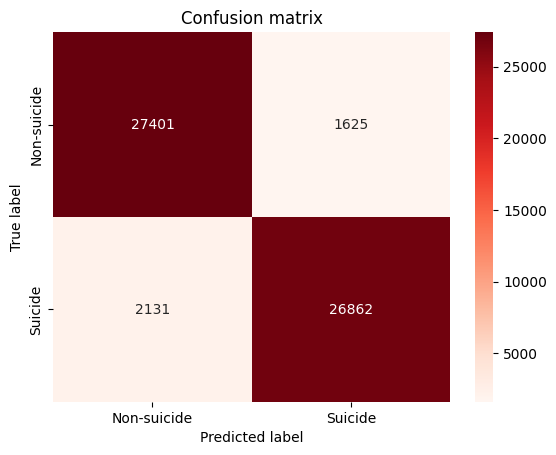

In [26]:
# Evaluation: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logreg)
# Define labels for the confusion matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non-suicide', 'Suicide']

# Create heatmap
sns.heatmap(cm, annot=True, cmap='Reds', xticklabels=categories, yticklabels=categories, fmt='g')

# Add labels to the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

# Naive Bayes

In [19]:
#Naive Bayes Classifier
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train, y_train)
#predicted y
y_pred_nb = naive_bayes_classifier.predict(X_test)

/common/home/projectgrps/IS424/IS424G5/jupyterlab-venv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/common/home/projectgrps/IS424/IS424G5/jupyterlab-venv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [20]:
print(metrics.classification_report(y_test, y_pred_nb, target_names=['Non-Suicide', 'Suicide']))


              precision    recall  f1-score   support

 Non-Suicide       0.95      0.84      0.89     29026
     Suicide       0.86      0.95      0.90     28993

    accuracy                           0.90     58019
   macro avg       0.90      0.90      0.90     58019
weighted avg       0.90      0.90      0.90     58019



In [21]:
print("Naive Bayes Accuracy Score -> ",accuracy_score(y_pred_nb, y_test)*100)


Naive Bayes Accuracy Score ->  89.82057601820094


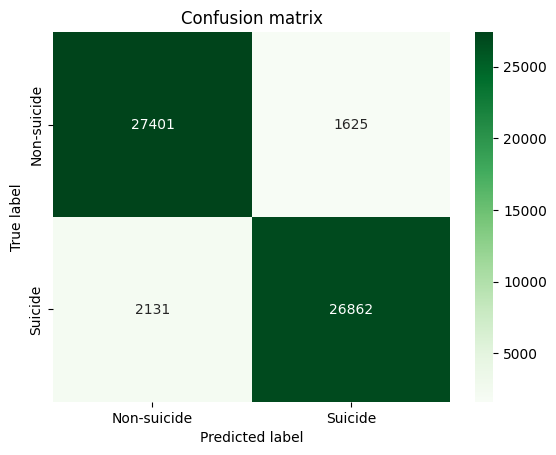

In [22]:
# Evaluation: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logreg)
# Define labels for the confusion matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non-suicide', 'Suicide']

# Create heatmap
sns.heatmap(cm, annot=True, cmap='Greens', xticklabels=categories, yticklabels=categories, fmt='g')

# Add labels to the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()